LSTM

In [ ]:
import os
import zipfile
import gdown
import numpy as np
import librosa
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# 1. Load YAMNet model
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')

# 2. Function to preprocess audio files
def preprocess_audio(file_path):
    audio, sr = librosa.load(file_path, sr=16000)  # Resample to 16kHz
    return audio


In [ ]:
# 3. Function to extract embeddings from YAMNet (mengembalikan sequence embeddings)
def extract_embeddings(audio):
    # Menghasilkan tuple: (scores, embeddings, spectrogram)
    _, embeddings, _ = yamnet_model(audio)
    return embeddings.numpy()  # shape: (num_frames, embedding_dim)

In [ ]:
# 4. Function for audio augmentation
def augment_audio(audio, sr):
    # Time Stretching
    audio_stretched = librosa.effects.time_stretch(audio, rate=1.1)
    # Pitch Shifting
    audio_shifted = librosa.effects.pitch_shift(audio, sr=sr, n_steps=2)
    # Tambahkan Noise
    noise = np.random.normal(0, 0.01, len(audio))
    audio_noisy = audio + noise
    return [audio_stretched, audio_shifted, audio_noisy]

In [ ]:
# 5. Download and extract the dataset from Google Drive
dataset_url = "https://drive.google.com/uc?id=1OdGtIQ4ZGhauIHMzuLt7hrMHARfVZeA5"
dataset_zip = "ravdess.zip"
gdown.download(dataset_url, dataset_zip, quiet=False)

with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall("ravdess_data")

DATASET_PATH = "ravdess_data"

Downloading...
From (original): https://drive.google.com/uc?id=1OdGtIQ4ZGhauIHMzuLt7hrMHARfVZeA5
From (redirected): https://drive.google.com/uc?id=1OdGtIQ4ZGhauIHMzuLt7hrMHARfVZeA5&confirm=t&uuid=33611e6a-57d4-4cc0-9173-197bae23b5f1
To: /content/ravdess.zip
100%|██████████| 450M/450M [00:10<00:00, 43.3MB/s]


In [ ]:
# 6. Ekstraksi fitur dan label
X, y = [], []
for root, _, files in os.walk(DATASET_PATH):
    for file in files:
        if file.endswith('.wav'):
            file_path = os.path.join(root, file)
            audio = preprocess_audio(file_path)
            embedding_seq = extract_embeddings(audio)  # sequence embeddings dengan shape (T, D)
            # Ambil label dari nama file (misalnya: '03-01-03-02-01-01-01.wav', label berada di indeks ke-2)
            label = file.split('-')[2]
            X.append(embedding_seq)
            y.append(label)

            # Augmentasi data
            augmented_audios = augment_audio(audio, sr=16000)
            for aug_audio in augmented_audios:
                aug_embedding_seq = extract_embeddings(aug_audio)
                X.append(aug_embedding_seq)
                y.append(label)

print(f"Total data setelah augmentasi: {len(X)} samples")

Total data setelah augmentasi: 11520 samples


In [ ]:
# 7. Padding sequences agar semua sample memiliki panjang yang sama
X_padded = pad_sequences(X, padding='post', dtype='float32')
print("Shape after padding:", X_padded.shape)  # (num_samples, max_length, embedding_dim)

# 8. Opsional: Normalisasi fitur
num_samples, max_len, emb_dim = X_padded.shape
X_reshaped = X_padded.reshape(-1, emb_dim)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reshaped)
X_scaled = X_scaled.reshape(num_samples, max_len, emb_dim)

Shape after padding: (11520, 10, 1024)


In [ ]:
# 9. Encode label menjadi angka
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# 10. Split data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)
print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

Training samples: 9216, Testing samples: 2304


In [ ]:
# 11. Membangun model LSTM
model = tf.keras.Sequential([
    # Masking layer untuk mengabaikan padding (mask_value=0 sesuai dengan padding yang digunakan)
    tf.keras.layers.Masking(mask_value=0., input_shape=(max_len, emb_dim)),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(np.unique(y_encoded)), activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# 12. Kompilasi model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking (Masking)                    │ (None, 10, 1024)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 10, 64)              │         278,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │             264 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 292,520 (1.12 MB)

 Trainable params: 292,520 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 13. Latih model
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
    ]
)


Epoch 1/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.2114 - loss: 1.9918 - val_accuracy: 0.3550 - val_loss: 1.7262 - learning_rate: 0.0010
Epoch 2/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.3577 - loss: 1.7003 - val_accuracy: 0.4049 - val_loss: 1.5249 - learning_rate: 0.0010
Epoch 3/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4376 - loss: 1.5169 - val_accuracy: 0.4766 - val_loss: 1.3582 - learning_rate: 0.0010
Epoch 4/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.4741 - loss: 1.4214 - val_accuracy: 0.5208 - val_loss: 1.2725 - learning_rate: 0.0010
Epoch 5/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5063 - loss: 1.3101 - val_accuracy: 0.5178 - val_loss: 1.2494 - learning_rate: 0.0010
Epoch 6/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5408 - loss: 1.2337 - val_accuracy: 0.5217 - val_loss: 1.2917 - learning_rate: 0.0010
Epoch 7/100
288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5560 - loss: 

In [ ]:
# 14. Evaluasi model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7783 - loss: 0.8723
Test Accuracy: 0.78


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


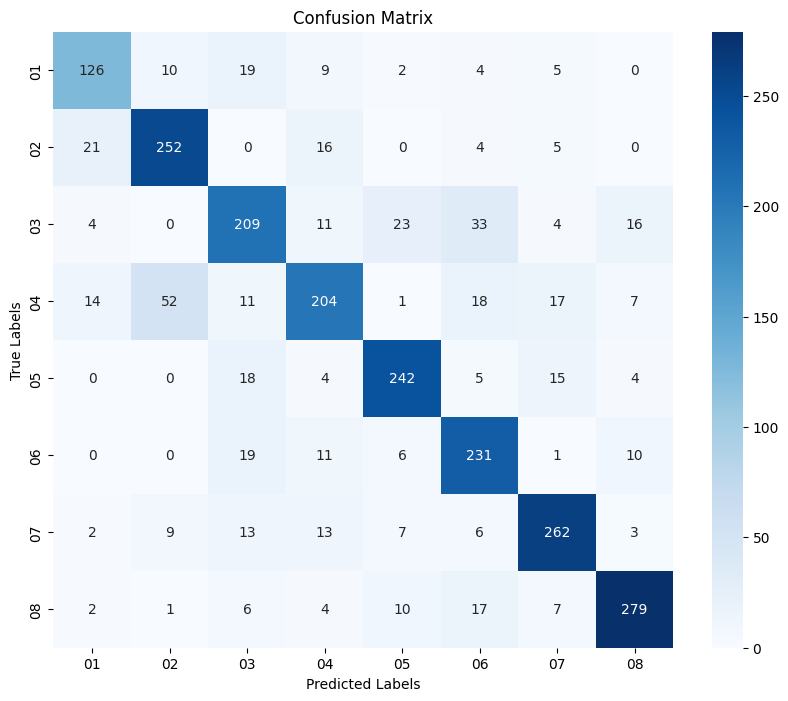

In [ ]:
# 15. Visualisasi Confusion Matrix
predictions = np.argmax(model.predict(X_test), axis=1)
conf_matrix = confusion_matrix(y_test, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
from IPython.display import Audio, display

In [ ]:
def predict_emotion_with_accuracy(file_path):
    # Preprocess file audio
    audio = preprocess_audio(file_path)
    # Ekstrak sequence embeddings
    embedding_seq = extract_embeddings(audio)  # shape: (T, emb_dim)

    # Padding sequence agar sesuai dengan max_len yang digunakan saat training
    padded_seq = pad_sequences([embedding_seq], maxlen=max_len, padding='post', dtype='float32')

    # Normalisasi menggunakan scaler yang sama (reshape dulu ke 2D, transform, lalu kembalikan ke 3D)
    padded_seq_scaled = scaler.transform(padded_seq.reshape(-1, emb_dim)).reshape(1, max_len, emb_dim)

    # Lakukan prediksi menggunakan model yang telah dilatih
    prediction = model.predict(padded_seq_scaled)
    predicted_label = encoder.inverse_transform([np.argmax(prediction)])[0]

    # Map numerical labels ke kategori emosi
    emotion_map = {
        '01': 'neutral',
        '02': 'calm',
        '03': 'happy',
        '04': 'sad',
        '05': 'angry',
        '06': 'fearful',
        '07': 'disgust',
        '08': 'surprised'
    }

    emotion_result = emotion_map.get(predicted_label, "Unknown Emotion")
    prediction_accuracy = np.max(prediction) * 100  # Akurasi prediksi dalam persentase

    return emotion_result, prediction_accuracy


In [ ]:
# Allow user to input the file path
input_file = input("Enter the path to your audio file: ")

# Prediksi emosi dan tampilkan hasil beserta akurasi
try:
    print("Playing the input audio...")
    display(Audio(input_file))  # Memutar file audio yang diinput user

    predicted_emotion, acc = predict_emotion_with_accuracy(input_file)
    print(f"Predicted Emotion: {predicted_emotion}")
    print(f"Prediction Accuracy: {acc:.2f}%")
except Exception as e:
    print(f"Error occurred: {e}")

Enter the path to your audio file: /content/ravdess_data/Actor_02/03-01-06-02-02-01-02.wav
Playing the input audio...


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted Emotion: fearful
Prediction Accuracy: 99.77%
